# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [578]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We set seed to better reproduce results later on.
np.random.seed(12345)

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [579]:
# Activation functions
def activate(activations, selected_function = "none"):
    
    if selected_function == "none":
        y = activations
    elif selected_function == "relu" :
        # TODO: Implement the "ReLU" activation function
        return np.maximum(0, activations)
    elif selected_function == "sigmoid" :
        # TODO: Implement another activation function activation function of your own choice.
        return 1 / (1 + np.exp(-activations))
    return y

In [580]:
# TODO Test your activation functions, is the returning values what you expect?

### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [581]:
def d_activate(activations, selected_function = "none"):
    if selected_function == "none":
        dy = np.ones_like(activations)
    elif selected_function == "relu":
        # TODO: Implement the "ReLU" derivative
        return (activations > 0).astype(float)
    elif selected_function == "sigmoid":
        # TODO: Implement the derivative of the activation function you chose yourself.
        s = 1 / (1 + np.exp(-activations))
        return s * (1 - s)
    return dy

In [582]:
# TODO Test your activation function derivatives, is the returning values what you expect?

### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [583]:
# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y):
    loss = np.mean((y_hat - y) ** 2) # TODO: Finish this function
    return loss


# TODO: Choose another loss function and implement it
def other_loss(y_hat, y):
    # Mean Absolute Error Loss.
    loss = np.mean(np.abs(y_hat - y)) # TODO: Finish this function
    return loss

The derivatives of the loss is with respect to the predicted value **y_hat**.

In [584]:
def d_MSE_loss(y_hat, y):
    dy = 2 * (y_hat - y) / y.shape[0]
    # TODO: Finish this function
    return dy

# TODO: Choose another loss function and implement it
def d_other_loss(y_hat, y):
    dy = np.sign(y_hat - y) / y.shape[0]
    # TODO: Finish this function
    return dy

### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [585]:
def propagate_forward(weights, activations, bias, activation_function="none"):
    
    # TODO: Add support for the use of bias
    dot_product = np.dot(weights, activations) + bias
    new_activations = activate(dot_product, activation_function)
    return new_activations

### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [586]:
# Calculates the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights and the input signal (activations).

def propagate_backward(weights, activations, dl_dz, bias, activation_function="none"):
    # NOTE: dl_dz is the derivative of the loss based on the previous layers activations/outputs

    # TODO: Add support for the use of bias

    dot_product = np.dot(weights, activations) + bias

    d_loss = d_activate(dot_product, activation_function) * dl_dz
    d_weights = np.dot(d_loss, activations.T)
    d_bias = np.sum(d_loss, axis=1, keepdims=True)
    d_activations = np.dot(weights.T, d_loss)
    
    return d_weights, d_bias, d_activations

## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [587]:
class NeuralNet(object):
    
    # Setup all parameters and activation functions.
    # This function runs directly when a new instance of this class is created.
    def __init__ (self, input_dim, output_dim, neurons = []):

        # NOTE: The "neurons" parameter is given as a list.
        # E.g., [4, 8, 4] means 4 neurons in layer 1, 8 neurons in layer 2 etc...

        # TODO: Add support for bias for each neuron in the code below.
        
        self.weights = [np.random.normal(0,2,(m, n)) for n,m in zip([input_dim] + neurons, neurons + [output_dim])]
        self.biases = [np.zeros((layer_size, 1)) for layer_size in neurons + [output_dim]]
        self.activation_functions = ["relu"] * len(neurons) + ["none"]
    
    
    # Predict the input throught the network and calculate the output.
    def forward(self, x):

        x = x.T
        # TODO: Add support for a bias for each neuron in the code below.
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            x = propagate_forward(layer_weights, x, layer_bias, layer_activation_function)

        return x.T
    
    
    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    # The weight updates are happening "in-place", thus we are only returning the loss from this function.
    # Note that this function can handle a variable size of the input (x), both full datasets or smaller parts of the dataset.
    def adjust_weights(self, x, y, learning_rate=1e-4):
                
        # TODO: Add support for a bias for each neuron and make sure these are learnt as well in the code below.

        activation = x.T
        activation_history = [activation] # NOTE: We need the previous (or intermediate) activations to make use of the "chain rule" (see lecture notes).
        
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation = propagate_forward(layer_weights, activation, layer_bias, layer_activation_function)
            activation_history.append(activation)
           
        # NOTE: The "activation" variable is changing as we go forward in the neural network.

        y_pred = activation_history[-1].T
        loss = MSE_loss(y_pred, y)
        d_activations = d_MSE_loss(y_pred, y).T # NOTE: The final output can be "seen as" the final activations, thus the name.
        
        for layer_weights, layer_activation_function, layer_bias, previous_activations in reversed(list(zip(self.weights, self.activation_functions, self.biases, activation_history))):

            d_weights, d_bias, d_activations = propagate_backward(layer_weights, previous_activations, d_activations, layer_bias, layer_activation_function)

            # NOTE: Here is where the weight update is happening.
            layer_weights -= learning_rate * d_weights
            layer_bias -= learning_rate * d_bias

        return loss
    
    
    # A function for the training of the network.
    def train_net(self, x, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False):
        
        # TODO: Add a training loop where the weights and biases of the network is learnt over several epochs.

        # TODO: Add support for mini batches. That is, in each epoch the data should be split into several
        #       smaller subsets and the model should be trained on each of these subsets one at a time.

        # TODO: Implement the use of validation data, that is, splitting the training data into training data and validation data.
        #       The validation data should be used to stop the training when the model stops to generalise and starts to overfit.
        #       This feature should be able to be turned on and off to test the difference.

        # NOTE: Make use of previously implemented functions here.

        n_samples = x.shape[0]
        # Optionally split the data into training and validation sets.
        if use_validation_data:
            split_idx = int(0.8 * n_samples)
            x_train, x_val = x[:split_idx], x[split_idx:]
            y_train, y_val = y[:split_idx], y[split_idx:]
        else:
            x_train, y_train = x, y
        
        history = []
        val_history = []
        for epoch in range(epochs):
            # Shuffle training data.
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]
            
            epoch_loss = 0
            # Process mini-batches.
            for i in range(0, x_train_shuffled.shape[0], batch_size):
                x_batch = x_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                loss = self.adjust_weights(x_batch, y_batch, learning_rate)
                epoch_loss += loss * x_batch.shape[0]
            epoch_loss /= x_train_shuffled.shape[0]
            history.append(epoch_loss)
            
            if use_validation_data:
                y_val_pred = self.forward(x_val)
                val_loss = MSE_loss(y_val_pred, y_val)
                val_history.append(val_loss)
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.6f}, Validation Loss: {val_loss:.6f}")
            else:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")
                
        if use_validation_data:
            return history, val_history
        else:
            return history
    

## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

Epoch 1/100, Loss: 2698.966772
Epoch 2/100, Loss: 284.583556
Epoch 3/100, Loss: 158.947125
Epoch 4/100, Loss: 107.744272
Epoch 5/100, Loss: 78.733304
Epoch 6/100, Loss: 62.068429
Epoch 7/100, Loss: 50.602083
Epoch 8/100, Loss: 41.825729
Epoch 9/100, Loss: 36.011734
Epoch 10/100, Loss: 31.299111
Epoch 11/100, Loss: 27.994224
Epoch 12/100, Loss: 25.407295
Epoch 13/100, Loss: 23.438379
Epoch 14/100, Loss: 21.800759
Epoch 15/100, Loss: 20.335908
Epoch 16/100, Loss: 19.058060
Epoch 17/100, Loss: 17.892654
Epoch 18/100, Loss: 16.861708
Epoch 19/100, Loss: 15.996864
Epoch 20/100, Loss: 15.204610
Epoch 21/100, Loss: 14.511176
Epoch 22/100, Loss: 13.819261
Epoch 23/100, Loss: 13.363225
Epoch 24/100, Loss: 12.779586
Epoch 25/100, Loss: 12.284097
Epoch 26/100, Loss: 11.867059
Epoch 27/100, Loss: 11.425341
Epoch 28/100, Loss: 11.026826
Epoch 29/100, Loss: 10.661832
Epoch 30/100, Loss: 10.314117
Epoch 31/100, Loss: 9.981986
Epoch 32/100, Loss: 9.682470
Epoch 33/100, Loss: 9.392987
Epoch 34/100, Los

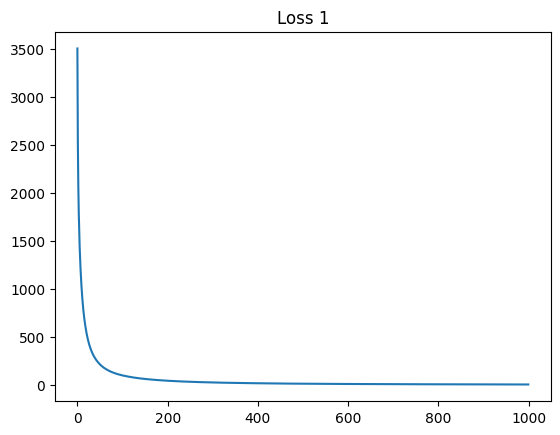

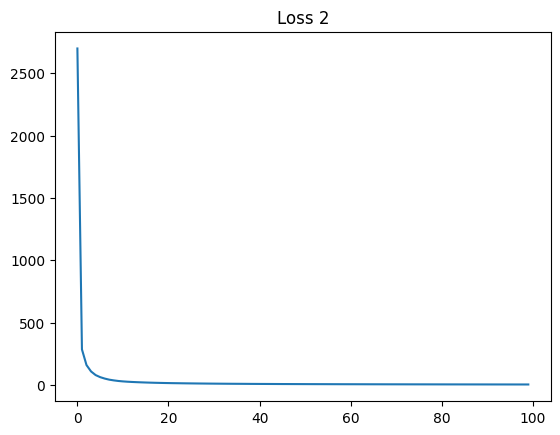

In [588]:
# TODO: You can change most things in this cell if you want to, we encurage it!

n = 1000
d = 4

k = np.random.randint(0,10,(d,1))
x = np.random.normal(0,1,(n,d))
y = np.dot(x,k) + 0.1 + np.random.normal(0,0.01,(n,1))

                        
nn = NeuralNet(d, 1, [18, 12])

loss_1 = [nn.adjust_weights(x, y) for _ in range(1000)] 

nn2 = NeuralNet(d, 1, [18, 12])
loss_2 = nn2.train_net(x, y) # TODO: Use the train_net function to compare with the "adjust_weights" function.

plt.plot(loss_1)
plt.title("Loss 1")
plt.show()

plt.plot(loss_2)
plt.title("Loss 2")
plt.show()

### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

### 8) Dataset 1: Wine - with and without scaling

Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

Train two neural network, one with scaling and one without. Are we able to see any difference in training results or loss over time?

**Note:** Do not train for to many epochs (more than maybe 50-100). The network might "learn" anyway in the end, but you should still be able to see a difference when training.

In [ ]:
from sklearn import preprocessing

data_wine = pd.read_csv("wine.csv").to_numpy()

# TODO: Set up the data and split it into train and test-sets.

# TODO: Train and test your neural networks.
# NOTE: Use the same train/test split for both neural network models!

# TODO: Do the above at least 3 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One combined lineplot with the scaling and one without the scaling, 2 plots in total.
# NOTE: Plot both the accuracy and the loss!

### Real data and hyper-parameter tuning

Now we are going to use real data, preprocess it, and do hyper-parameter tuning.

Choose two hyper-parameters to tune to try and achive an even better result.

**NOTE:** Changing the number of epochs should be part of the tuning, but it does not count towards the two hyper parameters.

### 9) Dataset 2: Mushroom

Mushroom dataset: https://archive.ics.uci.edu/dataset/73/mushroom

Note: This dataset has one feature with missing values. Remove this feature.

In [ ]:
data_mushroom = pd.read_csv("mushroom.csv").to_numpy()

# TODO: Preprocess the data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [ ]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

### 10) Dataset 3: Adult

Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

**IMPORTANT NOTE:** This dataset is much larger than the previous two (48843 instances). If your code runs slow on your own computer, you may exclude parts of this dataset, but you must keep a minimum of 10000 datapoints.

In [ ]:
dataset_3 = pd.read(...) # TODO: Read the data.

# TODO: Preprocess the data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [ ]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why would we want to use different activation functions?

2) Why would we want to use different loss functions?

3) Why are neural networks sensitive to large input values?

4) What is the role of the bias? 

5) What is the purpose of hyper-parameter tuning?

6) A small example neural network will be shown during the oral examination. You will be asked a few basic questions related to the number of weights, biases, inputs and outputs.

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!